# Machine Learning Project
## Paper: Factorization meets the neighborhood- a multifaceted collaborative filtering model

### Students:
Bernardo CARDOSO CORDEIRO <br>
Gauthier DAMIEN <br>
Hugo RICHARD

In [1]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import gzip
import random
import math
import operator
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Function and class definitions

In [2]:
def getDF(min_item=100, min_user=5):
    """Gets the dataset from Amazon
    min_item is the minimum number of ratings an item must have received to be in the dataset
    min_user is the minimum number of ratings a user must have given to be in the dataset"""
    
    #load data
    columns = ["userID", "itemID", "rating", "timestamp"]
    data = pd.read_csv("ratings_Musical_Instruments.csv", names=columns)
    #Take relevant items
    df2 = data.groupby(["itemID"]).count()
    sl2 = list(df2[df2["userID"] > min_item].index)
    df = data[data['itemID'].isin(sl2)]
    #Take relevant users
    df3 = df.groupby(["userID"]).count()
    sl3 = list(df3[df3["itemID"] > min_user].index)
    df_final = df[df['userID'].isin(sl3)]
    return df_final

In [3]:
def generate_toy(n_users=50, n_products=1000, p=0.1):
    """Generates random dataset"""
    columns = ["userID", "itemID", "rating", "timestamp"]
    n_ratings = int(n_users*n_products*p)
    dataset = np.empty([n_ratings, 4])
    
    #Scored dict keeps track of which pairs u,i have already received a score
    scored = {}
    for j in range(n_ratings):
        already_scored = True
        while already_scored:
            u = random.randint(1,n_users)
            i = random.randint(1,n_products)
            if u in scored:
                if i in scored[u]:
                    already_scored = True
                else:
                    already_scored = False
                    scored[u][i] = 1
            else:
                already_scored = False
                scored[u] = {}
                scored[u][i] = 0
        score = random.randint(1,5)
        dataset[j] = [u, i, score, j]
    df = pd.DataFrame(dataset, columns=columns)
    df.sort_values('itemID', inplace=True)
    return df

In [11]:
class rec_model:
    """Class implementing the recommender system model"""
    
    def __init__(self, df):
        """Builds a sparse matrix of the rating to be used for the similarity
        Moreover, makes a mapping of the indexes in the matrix to the items/user IDs and vice-versa"""
        
        users = df['userID'].unique()
        items = df['itemID'].unique()
        n_users = users.shape[0]
        n_items = items.shape[0]

        u_to_index = {}
        i_to_index = {}
        index_to_i = {}

        for i in range(len(users)):
            u_to_index[users[i]] = i
        for i in range(len(items)):
            i_to_index[items[i]] = i
            index_to_i[i] = items[i]

        ratings = csr_matrix((n_items, n_users))
        for index, row in df.iterrows():
            i = row['itemID']
            u = row['userID']
            ratings[i_to_index[i], u_to_index[u]] = row['rating']
            
        self.ratings = ratings
        self.u_to_index = u_to_index
        self.i_to_index = i_to_index
        self.index_to_i = index_to_i
    
    def fast_Sk(self, k=5):
        """Calculates similarity and finds k-most similar items
        Uses sparse matrices, which makes it fast to compute"""
        
        sim = self.ratings.dot(self.ratings.transpose())
        norms = np.array([np.sqrt(sim.diagonal())])
        Sk = {}
        for i in range(sim.shape[0]):
            Sk[self.index_to_i[i]] = []
            if not np.all(norms):
                print "Norm contains zero! Values might contain NaNs!"
            row = (sim.getrow(i).toarray() / norms / norms.T[i])[0]
            sorted_row = np.argsort(row)
            sorted_row = sorted_row[-5:]
            for index in sorted_row:
                if row[index] != 0:
                    Sk[self.index_to_i[i]].append(self.index_to_i[index])
        return Sk
        
    def calculate_baseline(self, df, gamma=0.01, lamb=0.01, n_iter=15):
        """Calculates baselines used in the model, as explained in the report"""
        
        mu = df['rating'].mean()

        n_items = len(df['itemID'].unique())
        n_users = len(df['userID'].unique())

        bias_u = {}
        bias_i = {}

        for user in df['userID'].unique():
            bias_u[user] = 0
        for item in df['itemID'].unique():
            bias_i[item] = 0

        for n in range(n_iter):
            for index, row in df.iterrows():
                rui = row['rating']
                bu = bias_u[row['userID']]
                bi = bias_i[row['itemID']]
                eui = rui - mu - bu - bi
                bias_u[row['userID']] = bu + gamma*(eui - lamb*bu)
                bias_i[row['itemID']] = bi + gamma*(eui - lamb*bi)
        return bias_u, bias_i

    def N_k(self, N, Sk, i, u):
        """Calculates Nk using N and Sk. In this case Rk and Nk are the same, as explained in the report"""
        intersect = []
        if u in N and i in Sk:
            for j in N[u]: 
                if j in Sk[i]:
                    intersect.append(j)
        return intersect
        
    def fit(self, df, g1=0.007, g2=0.007, g3=0.001, l6 = 0.005, l7=0.015, l8=0.015, rf=3, n_iter=15, verbose=False):
        """Fits the model to the data"""
        self.rf = rf
        pu = {}
        qi = {}
        y = {}

        if verbose:
            print "Initializing pu, qi, y, c, w and rui_dict... "

        for user in df['userID'].unique():
            pu[user] = np.ones((rf,1))
        for item in df['itemID'].unique():
            qi[item] = np.ones((rf,1))
            y[item] = np.ones((rf,1))

        c = {}
        w = {}
        rui_dict = {}
        for index, row in df.iterrows():
            u = row['userID']
            i = row['itemID']
            if u not in rui_dict:
                rui_dict[u] = {}
            rui_dict[u][i] = row['rating']
            
        if np.any(np.isnan(pu.values())) or np.any(np.isnan(qi.values())) or np.any(np.isnan(y.values())):
            print "Nan values present..."
        
        if verbose:
            print "Done!\nInitializing N... "

        N = {}
        items_by_user = df.drop(['timestamp'], axis=1).groupby(['userID'])
        for u, group in items_by_user:
            N[u] = np.array(group['itemID'])
            
        if verbose:
            print "Done!\nCalculating baselines... "

        bias_u, bias_i = self.calculate_baseline(df)
        
        if np.any(np.isnan(bias_u.values())) or np.any(np.isnan(bias_i.values())):
            "Nan values present in baseline..."

        mu = df['rating'].mean()
        b_u = {}
        b_i = {}
        for user in df['userID'].unique():
            b_u[user] = 0
        for item in df['itemID'].unique():
            b_i[item] = 0

        if verbose:
            print "Done!\nCalculating similarities... "
            
        Sk = self.fast_Sk(k = 5)

        if verbose:
            print "Done!\nIterating through dataset... \n"

        for n in range(n_iter):
            if verbose:
                print "Iteration number: " + str(n) + "\n"
            for index, row in df.iterrows():
                rui = row['rating']
                u = row['userID']
                i = row['itemID']

                sum_yj = np.zeros((rf,1))
                for j in N[u]:
                    sum_yj += y[j] 

                Nk = self.N_k(N, Sk, i, u)

                sum_cij = 0
                sum_wij = 0
                for j in Nk:
                    if i not in c:
                        c[i] = {}
                    if j not in c[i]:
                        c[i][j] = 0
                    if np.isnan(c[i][j]):
                        print "Nan in cij, i and j: " + str(i) + ' ' + str(j)
                    sum_cij += c[i][j]

                    if i not in w:
                        w[i] = {}
                    if j not in w[i]:
                        w[i][j] = 0
                    if np.isnan(w[i][j]):
                        print "Nan in wij, i and j: " + str(i) + ' ' + str(j)
                    sum_wij += w[i][j]*(rui_dict[u][j] - mu - bias_u[u] - bias_i[j])
                    
                    
                if len(Nk) != 0:
                    C_Nk=math.pow(len(Nk), -0.5)
                else:
                    C_Nk=0
                if len(N[u]) != 0:
                    C_N=math.pow(len(N[u]), -0.5)
                else:
                    C_N=0
                rui_e = mu + b_u[u] + b_i[i] + qi[i].T.dot(pu[u] + C_N*sum_yj) + C_Nk*(sum_cij + sum_wij)
                if np.isnan(rui_e) or np.isinf(rui_e):
                    print mu, b_u[u], b_i[i], qi[i], pu[u], C_N, sum_yj, C_Nk, sum_cij, sum_wij
                eui = rui - rui_e

                b_u[u] += g1*(eui - l6*b_u[u])
                b_i[i] += g1*(eui - l6*b_i[i])
                qi[i] += g2*(eui*(pu[u] + C_N*sum_yj) - l7*qi[i])
                pu[u] += g2*(eui*qi[i] - l7*pu[u])
                for j in N[u]:
                    y[j] += g2*(eui*C_N*qi[i] - l7*y[j])
                for j in Nk:
                    w[i][j] += g3*(C_Nk*eui*(rui_dict[u][j] - mu - bias_u[u] - bias_i[j]) - l8*w[i][j])
                    c[i][j] += g3*(C_Nk*eui - l8*c[i][j])
        if verbose:
            print "Done!\nStoring final parameter values... "
            
        self.pu = pu
        self.qi = qi
        self.y = y
        self.c = c
        self.w = w
        self.b_u = b_u
        self.b_i = b_i
        self.rui_dict = rui_dict
        self.bias_u = bias_u
        self.bias_i = bias_i
        self.mu = mu
        self.N = N
        self.Sk = Sk
        
        if verbose:
            print "All done!\n"
    
    def estimate(self, u, i):
        """Estimates the rating user u would give to item i"""
        bu = 0
        bi = 0
        q = np.zeros((self.rf,1))
        p = np.zeros((self.rf,1))
        if u in self.b_u:
            bu = self.b_u[u]
        if i in self.b_i:
            bi = self.b_i[i]
        if i in self.qi:
            q = self.qi[i]
        if u in self.pu:
            p = self.pu[u]
            
        sum_yj = np.zeros((self.rf,1))
        if u in self.N:
            for j in self.N[u]:
                if j in self.y:
                    sum_yj += self.y[j]

        Nk = self.N_k(self.N, self.Sk, i, u)

        sum_cij = 0
        sum_wij = 0
        for j in Nk:
            if i in self.c:
                if j in self.c[i]:
                    sum_cij += self.c[i][j]

            if i in self.w and u in self.rui_dict:
                if j in self.w[i] and j in self.rui_dict[u]:
                    bias_user = 0
                    bias_item = 0
                    if u in self.bias_u:
                        bias_user = self.bias_u[u]
                    if j in self.bias_i:
                        bias_item = self.bias_i[j]
                    sum_wij += self.w[i][j]*(self.rui_dict[u][j] - self.mu - bias_user - bias_item)
                    
        if len(Nk) != 0:
            C_Nk=math.pow(len(Nk), -0.5)
        else:
            C_Nk=0
        C_N=0
        if u in self.N:
            if len(self.N[u]) != 0:
                C_N=math.pow(len(self.N[u]), -0.5)   
        rui_e = self.mu + bu + bi + q.T.dot(p + C_N*sum_yj) + C_Nk*(sum_cij + sum_wij)
        return rui_e[0][0]

## Amazon

Warning: values in range function represent the number of iterations to be run for the model (and then used to make a plot). High values will take more time, so change them accordingly

200
400
600
800
1000


C:\Users\Berne\Anaconda2\lib\site-packages\scipy\sparse\compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


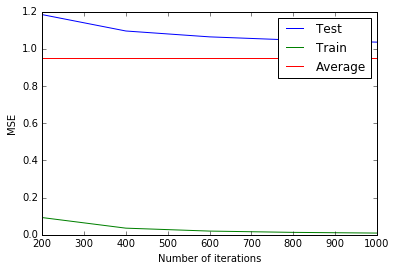

In [5]:
df = getDF(20, 5)
df_train, df_test = train_test_split(df)
model = rec_model(df_train)

n_it = []
mse_test = []
mse_train = []
#Values for the number of iterations
for n in range(200,1001,200):
    print n
    n_it.append(n)
    model.fit(df_train, n_iter=n, g1=0.001, g2=0.001, verbose=False)

    rui_pred_test = []
    rui_pred_train = []
    rui_test = []
    rui_train = []
    for index, row in df_test.iterrows():
        u = row['userID']
        i = row['itemID']
        rui_test.append(row['rating'])
        est = model.estimate(u, i)
        rui_pred_test.append(est)
    for index, row in df_train.iterrows():
        u = row['userID']
        i = row['itemID']
        rui_train.append(row['rating'])
        est = model.estimate(u, i)
        rui_pred_train.append(est)
    mse_test.append(mean_squared_error(rui_test, rui_pred_test))
    mse_train.append(mean_squared_error(rui_train, rui_pred_train))
    
m = df_train['rating'].mean()
rui_pred_m = [m for i in range(len(df_test))]
m_mse = mean_squared_error(rui_test, rui_pred_m)
m_mse_plot = [m_mse for i in range(len(mse_test))]

l1, = plt.plot(n_it, mse_test, c="b", label="Test")
l2, = plt.plot(n_it, mse_train, c="g", label="Train")
l3, = plt.plot(n_it, m_mse_plot, c="r", label="Average")
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.legend([l1, l2, l3], ['Test', 'Train', 'Average'])

This graph, as well as the other one below for a smaller number of iterations, show that the MSE decreases with the number of iterations, which is expected. It is worth noting that no optimization of the hyperparameters was made, so these results might not be the best ones.

### WARNING
Running the next cell again will cause the plot to be lost/replaced!!

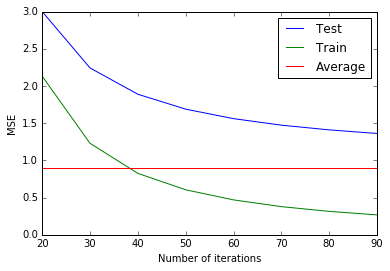

In [17]:
l1, = plt.plot(n_it, mse_test, c="b", label="Test")
l2, = plt.plot(n_it, mse_train, c="g", label="Train")
l3, = plt.plot(n_it, m_mse_plot, c="r", label="Average")
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.legend([l1, l2, l3], ['Test', 'Train', 'Average'])

This last plot takes number of iterations from 20 to 90, incrementing by 10 each time.

## Toy

20
30
40
50
60
70
80
90


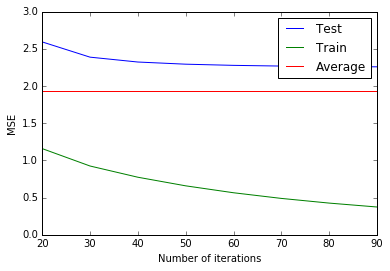

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

df = generate_toy(50, 100, 0.2)
df_train, df_test = train_test_split(df)
model = rec_model(df_train)

n_it = []
mse_test = []
mse_train = []
for n in range(20,100,10):
    print n
    n_it.append(n)
    model.fit(df_train, n_iter=n, g1=0.001, g2=0.001, verbose=False)

    rui_pred_test = []
    rui_pred_train = []
    rui_test = []
    rui_train = []
    for index, row in df_test.iterrows():
        u = row['userID']
        i = row['itemID']
        rui_test.append(row['rating'])
        est = model.estimate(u, i)
        rui_pred_test.append(est)
    for index, row in df_train.iterrows():
        u = row['userID']
        i = row['itemID']
        rui_train.append(row['rating'])
        est = model.estimate(u, i)
        rui_pred_train.append(est)
    mse_test.append(mean_squared_error(rui_test, rui_pred_test))
    mse_train.append(mean_squared_error(rui_train, rui_pred_train))
    
m = df_train['rating'].mean()
rui_pred_m = [m for i in range(len(df_test))]
m_mse = mean_squared_error(rui_test, rui_pred_m)
m_mse_plot = [m_mse for i in range(len(mse_test))]

l1, = plt.plot(n_it, mse_test, c="b", label="Test")
l2, = plt.plot(n_it, mse_train, c="g", label="Train")
l3, = plt.plot(n_it, m_mse_plot, c="r", label="Average")
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.legend([l1, l2, l3], ['Test', 'Train', 'Average'])

### WARNING
Rerunning the cell below will overwrite the graph, since this was obtained with a different number of iterations

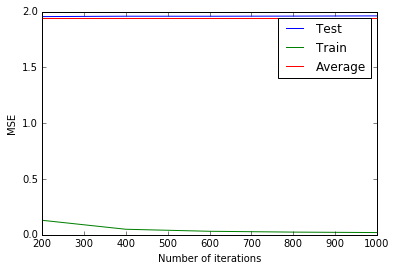

In [8]:
l1, = plt.plot(n_it, mse_test, c="b", label="Test")
l2, = plt.plot(n_it, mse_train, c="g", label="Train")
l3, = plt.plot(n_it, m_mse_plot, c="r", label="Average")
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.legend([l1, l2, l3], ['Test', 'Train', 'Average'])

In this graph, we see that, apparently, the MSE for the test converges to the MSE given by the using the traning set average rating as the prediction.

### LOO-CV code
Code used for LOO-CV: takes quite a while to run. Had to run it in a separate script which is why the result is not available here. The given result for the toy dataset was 2.29, with n_iter = 15. Given the graph above, this result is not unexpected. It was not tested with the Amazon dataset due to its size.

In [ ]:
from sklearn.model_selection import train_test_split
#V-fold CV
rui = []
rui_pred = []
for i in range(len(df)):
    print i
    df_test = df[i:i+1]
    df_train = df.drop(df.index[[i]])
    model = rec_model(df)
    model.fit(df_train, n_iter=15)
    rui.append(np.array(df_test['rating'])[0])
    rui_pred.append(model.estimate(np.array(df_test['userID'])[0], np.array(df_test['itemID'])[0]))